<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/edes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
# Se corre una vez al abrir una nueva sesión
# !pip install yfinance
# !pip install fitter
# !pip install pingouin

In [202]:
import numpy as np
import random as rnd

import pandas as pd
import pingouin as pg
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import shapiro, normaltest, anderson

import matplotlib.pyplot as plt #gráficas
import matplotlib as mpl

import seaborn as sns #gráficas
plt.style.use('ggplot') #estilo de graficas

# Pronóstico 1: EDE Homogénea

\begin{equation}
  dX_t = F(t)X_tdt + G(t)X_tdB_t, \quad X_{t_0} = X_0
\end{equation}

definida sobre $[t_0, T]$, donde ${F,G}$ son funciones deterministas continuas de valores en $\mathbb{R}$ y $\{B_t\}_{t \geq 0}$ es un MBEU. Su solución es

\begin{equation}
  X_t = X_0 \exp\Bigg[{\int_{t_0}^t}\bigg(F(s)-\frac{1}{2}G(s)^2\bigg)ds + \int_{t_0}^t G(s) dB_s \Bigg]
\end{equation}

## 2.


En este caso $F(t)=\mu$ y $G(t)=\sigma$, con $\mu \in [0,1]$ y $\sigma \in [0,0.4]$. Entonces se tiene la EDE homogénea 

\begin{equation}
  dX_t = \mu X_tdt + \sigma X_tdB_t
\end{equation}

con solución

\begin{equation}
  X_t = X_0 \exp\Bigg[{\int_{t_0}^t}\bigg(\mu-\frac{1}{2}\sigma^2\bigg)ds + \int_{t_0}^t \sigma dB_s \Bigg]
\end{equation}

discretizando con Euler-Maruyama

\begin{equation}
  X(t) = X(t-1) \exp\Bigg[\bigg(\mu - \frac{1}{2}\sigma^2\bigg)\Delta t + \sigma \Delta B_t\Bigg], \quad X(0) = 1
\end{equation}

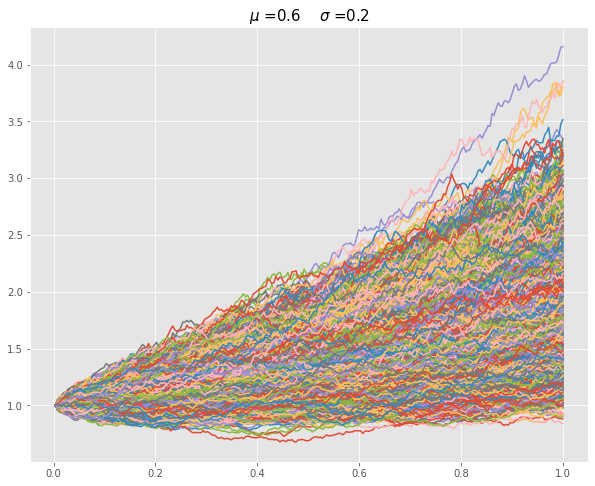

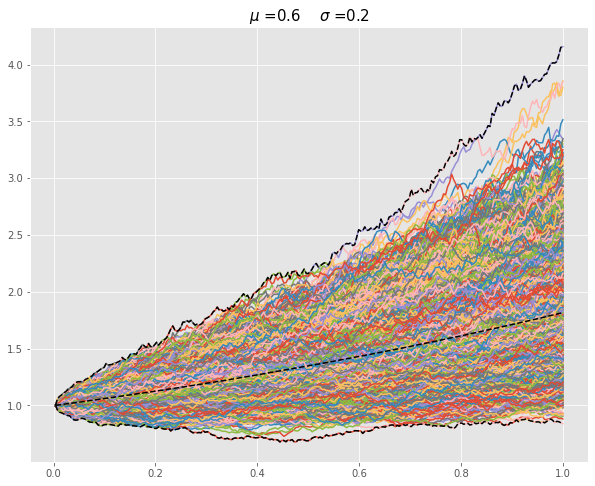

In [218]:
# EDE Lineal Homogénea
l = 10000 # número de simulaciones
p = 252 # número de observaciones

X = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado
X0 = 1 # Valor inicial
mu = 0.6
sigma = 0.2

fig = plt.figure(1, figsize=(10,8))
for sim in range(l): # Ciclo de simulaciones
  X[sim,0] = X0
  # mu = rnd.random()
  # sigma = rnd.random()*0.4
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución discreta
    X[sim, t] = X[sim, t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*dBt)
  plt.plot(T, X[sim]);

plt.title('$\mu$ =' + str(round(mu, 4)) + '    $\sigma$ =' + str(round(sigma,4)), fontsize = 15);

display(fig)

# Análisis longitudinal
X_max = np.amax(X, axis=0)
X_min = np.amin(X, axis=0)
X_mean = np.mean(X, axis=0)

plt.plot(T, X_max, '--', color='black');
plt.plot(T, X_min, '--', color='black');
plt.plot(T, X_mean, '--', color='black');

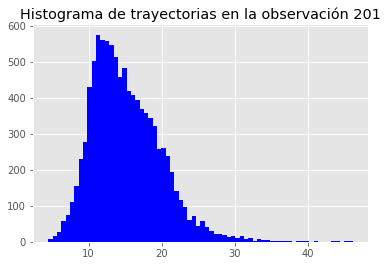

In [204]:
# Análisis transversal
X_tra = X[:, 200]

_ = plt.hist(X_tra, bins='auto', color='blue')
plt.title('Histograma de trayectorias en la observación 201');

,sumsquare_error,aic,bic,kl_div
lognorm,0.002394,1127.008626,-152422.369572,inf
gamma,0.002420,1172.759364,-152315.737516,inf
beta,0.004915,1393.530623,-145221.255076,inf
norm,0.009250,1584.651910,-138916.400668,inf


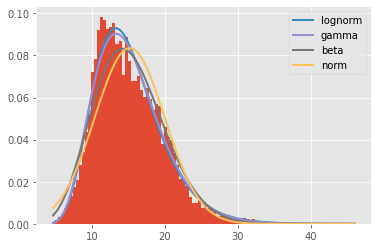

In [205]:
from fitter import Fitter, get_common_distributions, get_distributions

f = Fitter(X_tra,
           distributions=['lognorm',
                          'gamma',
                          "beta",
                          "norm"])
f.fit()
f.summary()

In [206]:
params = f.fitted_param["lognorm"]
params

# Buscar por qué tiene 3

(0.29105900843131866, -0.8434323605090048, 15.37343026054667)

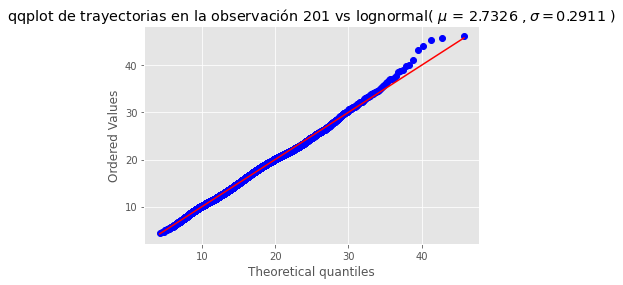

In [207]:
import pylab 
import scipy.stats as stats

sigma_hat = str(round(params[0],4))
mu_hat = str(round(np.log(params[2]), 4))

fig = plt.figure()
stats.probplot(X_tra, dist=stats.lognorm, sparams=params, plot=pylab);
plt.title('qqplot de trayectorias en la observación 201 vs lognormal( $\mu$ = ' + mu_hat + ' $,\sigma = $' + sigma_hat + ' )');

In [208]:
# Autocorrelación parcial PACF
import pandas as pd
from statsmodels.tsa.stattools import pacf
df = pd.DataFrame(X)
df_pacf = pd.DataFrame([pacf(df.iloc[i,:].to_numpy()) for i in range(10000)])


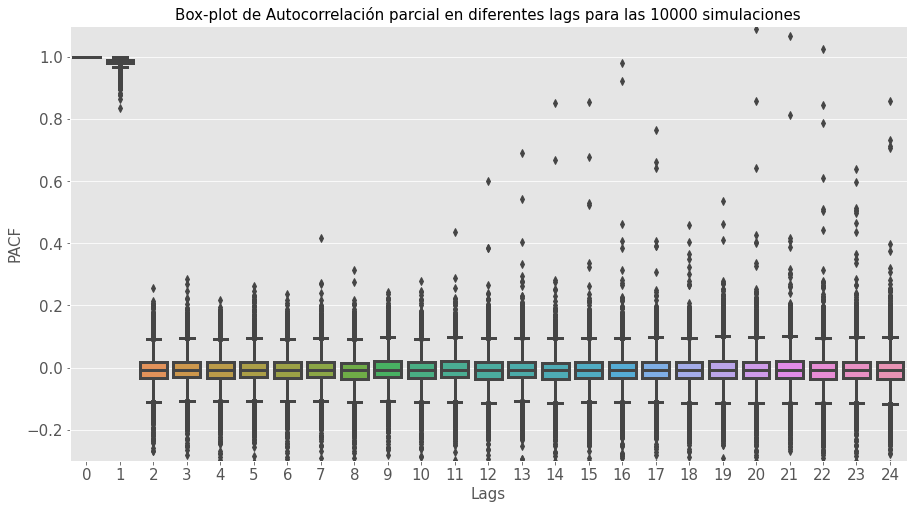

In [209]:
# Visualizar

plt.figure(figsize = (15, 8));
sns.boxplot(data = df_pacf, linewidth = 3);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Lags', fontsize = 15);
plt.ylabel('PACF', fontsize = 15);
plt.title('Box-plot de Autocorrelación parcial en diferentes lags para las ' + str(l) + ' simulaciones'
, fontsize = 15);


plt.ylim([-0.3, 1.1]);

In [210]:
# Condiciones a nivel de distribución

def test_normalidad(data):
  rendimientos =  np.log(df.T).diff().dropna()

  norm = rendimientos.agg(normaltest).iloc[1,:]
  shap = rendimientos.agg(shapiro).iloc[1,:]
  ande = rendimientos.agg(anderson)
  ande_cv = ande.iloc[1][0][2]
  ande = ande.iloc[0]

  norm = norm[norm > 0.05].count()
  shap = shap[shap > 0.05].count()
  ande = ande[ande < ande_cv].count()

  resul_uni = 100*np.array([norm/l, shap/l, ande/l])
  tests_uni = ['Shapiro', 'K^2', 'Anderson-Darling']

  if rendimientos.shape[1] > 1: # Multivariado

    count1 = 0
    for i in range(200):
      r = pg.multivariate_normality(rendimientos.iloc[:,0+50*i:50*(i+1)], alpha=.05)
      if r.normal:
        count1 += r.normal

    count2 = 0
    for i in range(2000):
      r = pg.multivariate_normality(rendimientos.iloc[:,0+5*i:5*(i+1)], alpha=.05)
      if r.normal:
        count2 += r.normal
    
    resul = np.append(resul_uni, 100*np.array([count1/200, count2/2000]))
    tests = tests_uni + ['HZ(200*50)', 'HZ(2000*5)']
  
  else:
    resul = resul_uni
    tests = tests_uni

  r = pd.DataFrame({'Test':tests, 'Éxito(%)':resul})
  return r
    

In [211]:
df = pd.DataFrame(X) # Datos como dataframe
r = test_normalidad(df)
r

,Test,Éxito(%)
0,Shapiro,95.07
1,K^2,95.13
2,Anderson-Darling,95.58
3,HZ(200*50),99.50
4,HZ(2000*5),95.60


In [212]:
# Dimensión fractal (Exponente de Hurst)
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [213]:
# lags = list(range(50,260,50)) # start, stop-step, step
# H = np.zeros((len(lags), l))
# fila = 0

# for lag in lags:
#   for col in df.T.columns:
#     H[fila,col] = np.apply_along_axis(get_hurst_exponent, 0, df.T[col].values, lag)
#   fila += 1

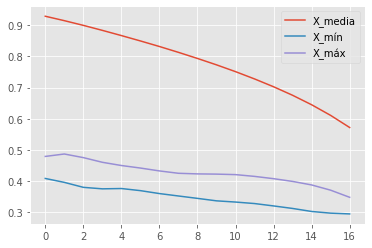

In [214]:
lags = list(range(50,220,10)) # start, stop-step, step
H_mean = np.zeros((len(lags), 1))
H_min = np.zeros((len(lags), 1))
H_max = np.zeros((len(lags), 1))
fila = 0

for lag in lags:
    H_mean[fila] = np.apply_along_axis(get_hurst_exponent, 0, np.transpose(X_mean), lag)
    H_min[fila] = np.apply_along_axis(get_hurst_exponent, 0, np.transpose(X_min), lag)
    H_max[fila] = np.apply_along_axis(get_hurst_exponent, 0, np.transpose(X_max), lag)
    fila += 1

H = np.concatenate((H_mean, H_min, H_max), axis=1)
H = pd.DataFrame(H)
H.columns = ['X_media', 'X_mín', 'X_máx']

plt.figure()
plt.plot(H)
plt.legend(H.columns);

## Esperanza y Varianza a largo plazo

La esperanza y varianza teóricas son

\begin{equation}
  \mathbb{E}[X_t] = X_0 e^{\mu t}
\end{equation}


\begin{equation}
  \mathbb{V}[X_t] = X_0^2 e^{2\mu t}\bigg(e^{\sigma^2t}-1\bigg)
\end{equation}

donde en este caso $X_0 = 1$

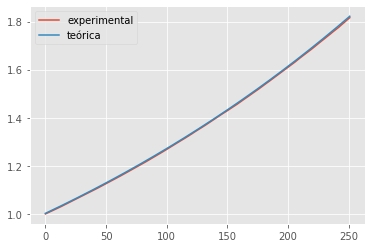

In [219]:
# Esperanza y Varianza de largo plazo

plt.figure()
plt.plot(X_mean)
plt.plot(X0*np.exp(mu*T))
plt.legend(['experimental', 'teórica'])

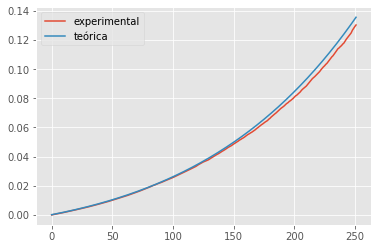

In [221]:
X_var = np.var(X, axis=0)
plt.plot(X_var)
plt.plot((X0**2)*np.exp(2*mu*T)*(np.exp((sigma**2)*T)-1))
plt.legend(['experimental', 'teórica'])

## 3.

In [217]:
# yfinance package de https://pypi.org/project/yfinance/

import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300,0.0,0.0
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700,0.0,0.0
2022-04-13,282.730011,288.579987,281.299988,287.619995,21907200,0.0,0.0
